# Importing and Cleaning

In [55]:
!pip install adjustText


In [56]:
from google.colab import drive
drive.mount('/content/drive')
import os
import calendar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import matplotlib.dates as mdates
from scipy import stats
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
os.chdir('/content/drive/MyDrive/Final Year Project/Data/Joined Datasets')
!pwd

/content/drive/MyDrive/Final Year Project/Data/Joined Datasets


In [58]:
df = pd.read_csv('test.csv')

In [59]:
df.head()

,Date,Flight Number,Airline,Aircraft Model,Departure Airport,Scheduled Departure,Estimated Departure,Actual Departure,Departure Terminal,Departure Gate,...,busiest_day,peak_season,Station,Observation Time,Wind Speed (KT),Visibility (m),Temperature (C),Dew Point (C),Pressure (hPa),Humidity (%)
0,2024-03-01,FR7044,Ryanair,B737,Dublin International,2024-03-01 05:45:00+00:00,2024-03-01 05:45:00+00:00,2024-03-01 06:02:00+00:00,1.0,107,...,1,0,EIDW,2024-03-01 05:30:00+00:00,14,10000.0,4,3,983,93.2
1,2024-03-01,MF9760,Xiamen Airlines,B737,Dublin International,2024-03-01 05:55:00+00:00,2024-03-01 05:55:00+00:00,2024-03-01 06:24:00+00:00,1.0,306,...,1,0,EIDW,2024-03-01 05:30:00+00:00,14,10000.0,4,3,983,93.2
2,2024-03-01,MU1898,China Eastern Airlines,A320,Dublin International,2024-03-01 05:55:00+00:00,2024-03-01 05:55:00+00:00,2024-03-01 06:24:00+00:00,1.0,306,...,1,0,EIDW,2024-03-01 05:30:00+00:00,14,10000.0,4,3,983,93.2
3,2024-03-01,KQ932,Kenya Airways,B737,Dublin International,2024-03-01 05:55:00+00:00,2024-03-01 05:55:00+00:00,2024-03-01 06:24:00+00:00,1.0,306,...,1,0,EIDW,2024-03-01 05:30:00+00:00,14,10000.0,4,3,983,93.2
4,2024-03-01,DL9609,Delta Air Lines,B767,Dublin International,2024-03-01 05:55:00+00:00,2024-03-01 05:55:00+00:00,2024-03-01 06:24:00+00:00,1.0,306,...,1,0,EIDW,2024-03-01 05:30:00+00:00,14,10000.0,4,3,983,93.2


In [60]:
# null values in the dataset
null_values = df.isnull().sum()

#columns with missing values
null_values[null_values > 0]

,0
Visibility (m),1


In [61]:
# Drop the row that are null
df = df.dropna(subset=['Visibility (m)'])

# Environmental Analysis

In [62]:
# maping the fuel burning level per size
fuel_use_per_minute = {
    1: 1.1,
    2: 1.8,
    3: 3.0,
    4: 4.1
}

df['FuelPerMinute'] = df['Aircraft Size'].map(fuel_use_per_minute)


In [63]:
# Calculating Excess fuel burned per minute
df['ExcessFuel_kg'] = df['Departure Delay'] * df['FuelPerMinute']


In [64]:
df['ExcessCO2_kg'] = df['ExcessFuel_kg'] * 3.16
#conversion rate for burning

In [65]:
# Calculate total excess emissions caused by delays
total_excess_emissions = df['ExcessCO2_kg'].sum()

# Group by airline and calculate:
# - Total emissions per airline
# - Total flights per airline
# - Average excess CO2 per flight (emissions rate)
airline_emissions = df.groupby('Airline').agg(
    TotalFlights=('Airline', 'count'),
    TotalExcessCO2=('ExcessCO2_kg', 'sum')
)

# average excess emissions per flight (emission rate)
airline_emissions['AvgExcessCO2_perFlight'] = airline_emissions['TotalExcessCO2'] / airline_emissions['TotalFlights']

# emission rate descending
airline_emissions_sorted = airline_emissions.sort_values(by='AvgExcessCO2_perFlight', ascending=False)
print(airline_emissions_sorted)


                        TotalFlights  TotalExcessCO2  AvgExcessCO2_perFlight
Airline                                                                     
Etihad Airways                   239       98525.640              412.241172
United Airlines                   28        9167.160              327.398571
Delta Air Lines                 1052      325239.840              309.163346
Air Canada                       205       61800.120              301.464000
American Airlines               3270      904145.520              276.497101
Qatar Airways                   1722      434089.200              252.084321
Qantas                            29        6455.880              222.616552
Emirates                          33        7271.160              220.338182
UPS Airlines                      31        6478.000              208.967742
Singapore Airlines                53       10674.480              201.405283
ANA                               51        9470.520              185.696471

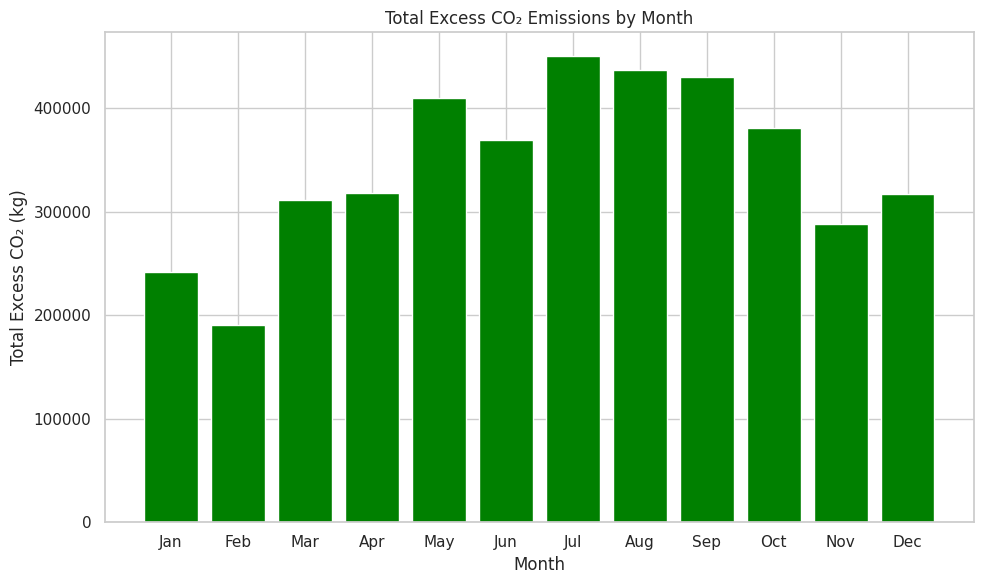

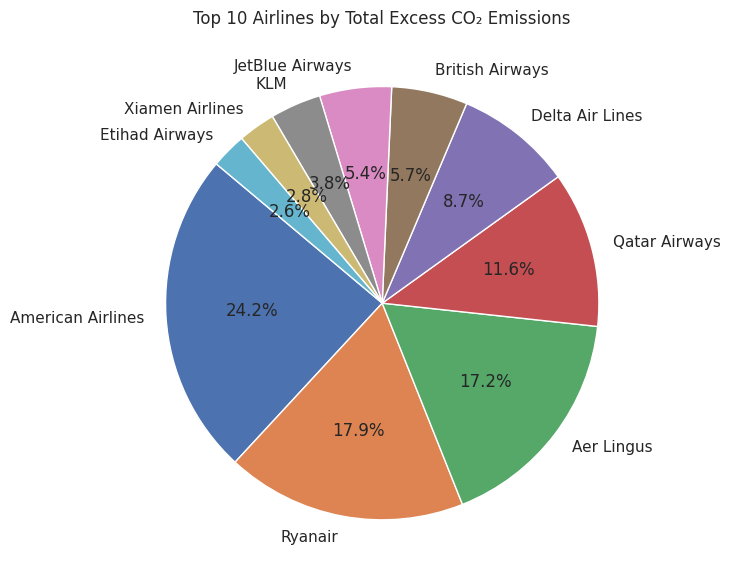

In [66]:
# date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])


# Extract month and day from the date
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.date

# Total CO2 per month
co2_by_month = df.groupby('month')['ExcessCO2_kg'].sum().reset_index()
co2_by_month['month'] = co2_by_month['month'].apply(lambda x: calendar.month_abbr[x])


# Total CO2 per day (for line plot)
co2_by_day = df.groupby('day')['ExcessCO2_kg'].sum().reset_index()


# Total CO2 by airline
co2_by_airline = df.groupby('Airline')['ExcessCO2_kg'].sum().sort_values(ascending=False).head(10).reset_index()


#CO2 by month Plot
plt.figure(figsize=(10, 6))
plt.bar(co2_by_month['month'], co2_by_month['ExcessCO2_kg'], color='green')
plt.title('Total Excess CO₂ Emissions by Month')
plt.xlabel('Month')
plt.ylabel('Total Excess CO₂ (kg)')
plt.tight_layout()
plt.show()


# Pie chart of top CO2 emitting airlines
plt.figure(figsize=(10, 6))
plt.pie(co2_by_airline['ExcessCO2_kg'], labels=co2_by_airline['Airline'], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Airlines by Total Excess CO₂ Emissions')
plt.tight_layout()
plt.show()


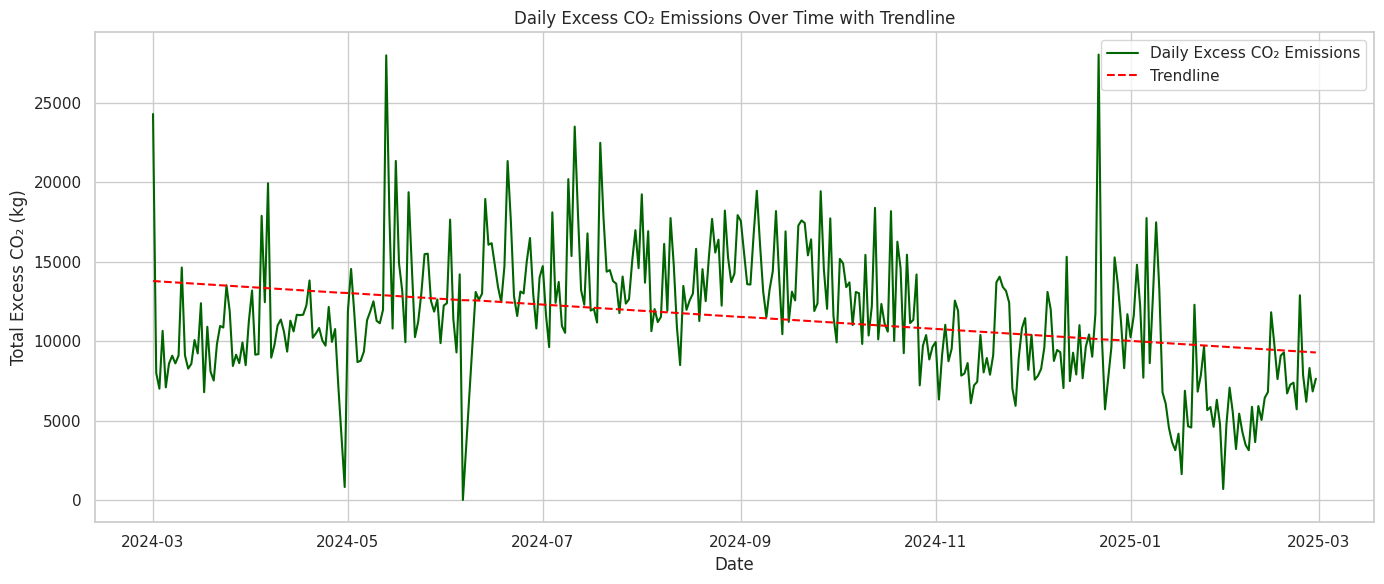

In [67]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract month and day from the date
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.date

# Total CO2 per month
co2_by_month = df.groupby('month')['ExcessCO2_kg'].sum().reset_index()
co2_by_month['month'] = co2_by_month['month'].apply(lambda x: calendar.month_abbr[x])

# Total CO2 per day (for line plot)
co2_by_day = df.groupby('day')['ExcessCO2_kg'].sum().reset_index()

# trendline
X = np.arange(len(co2_by_day)).reshape(-1, 1)
y = co2_by_day['ExcessCO2_kg'].values
model = LinearRegression().fit(X, y)
trendline = model.predict(X)

# Plot CO2 by day with a trendline
plt.figure(figsize=(14, 6))
plt.plot(co2_by_day['day'], co2_by_day['ExcessCO2_kg'], color='darkgreen', label='Daily Excess CO₂ Emissions')

# trendline
plt.plot(co2_by_day['day'], trendline, color='red', linestyle='--', label='Trendline')

# Title and labels
plt.title('Daily Excess CO₂ Emissions Over Time with Trendline')
plt.xlabel('Date')
plt.ylabel('Total Excess CO₂ (kg)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

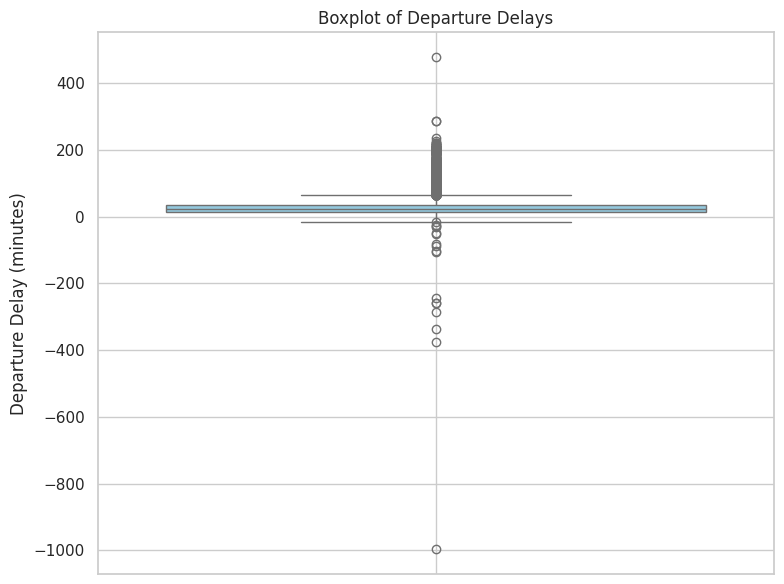

In [68]:
# Parse datetime columns
df['Scheduled Departure'] = pd.to_datetime(df['Scheduled Departure'])
df['Actual Departure'] = pd.to_datetime(df['Actual Departure'])

# Calculate delay in minutes
df['delay_minutes'] = (df['Actual Departure'] - df['Scheduled Departure']).dt.total_seconds() / 60

# Boxplot of departure delays including outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='delay_minutes', color='skyblue')
plt.title('Boxplot of Departure Delays')
plt.ylabel('Departure Delay (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

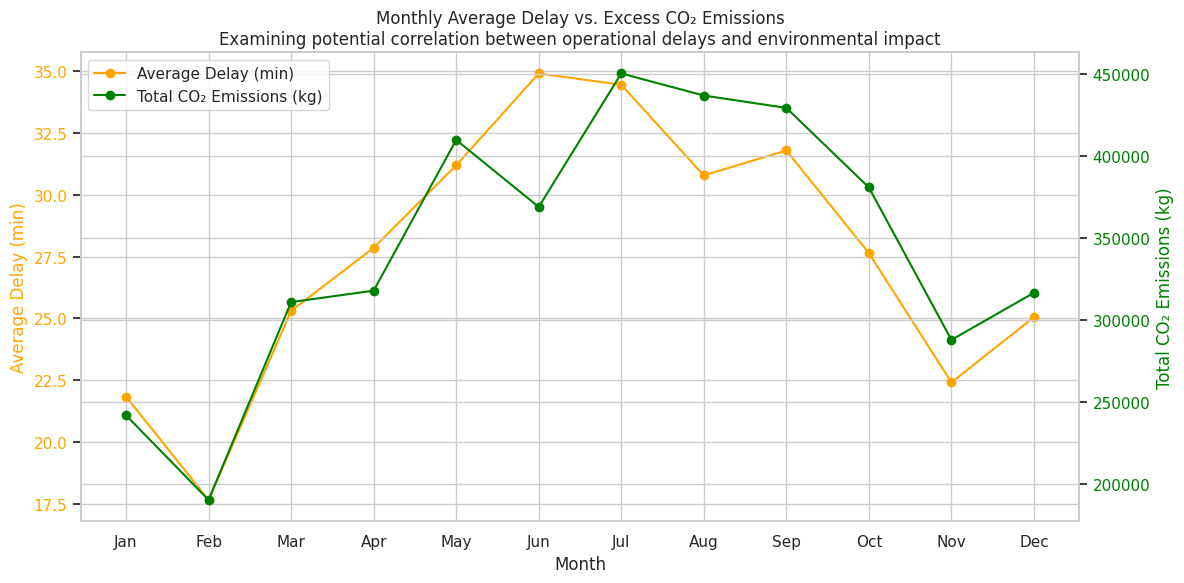

In [69]:
# average delay per month
monthly_avg_delay = df.groupby('month')['delay_minutes'].mean().reset_index()
monthly_avg_delay['month'] = monthly_avg_delay['month'].apply(lambda x: calendar.month_abbr[x])

# Merge with CO2 data
combined_monthly = pd.merge(monthly_avg_delay, co2_by_month, on='month')

# sort months in chronological order
month_order = list(calendar.month_abbr)[1:]  # ['Jan', 'Feb', ..., 'Dec']
combined_monthly['month'] = pd.Categorical(combined_monthly['month'], categories=month_order, ordered=True)
combined_monthly.sort_values('month', inplace=True)

# Dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 6))

#average delay
ax1.plot(combined_monthly['month'], combined_monthly['delay_minutes'], color='orange', marker='o', label='Average Delay (min)')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Delay (min)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# CO2 emissions
ax2 = ax1.twinx()
ax2.plot(combined_monthly['month'], combined_monthly['ExcessCO2_kg'], color='green', marker='o', label='Total CO₂ Emissions (kg)')
ax2.set_ylabel('Total CO₂ Emissions (kg)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and subtitle
plt.title('Monthly Average Delay vs. Excess CO₂ Emissions\nExamining potential correlation between operational delays and environmental impact')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

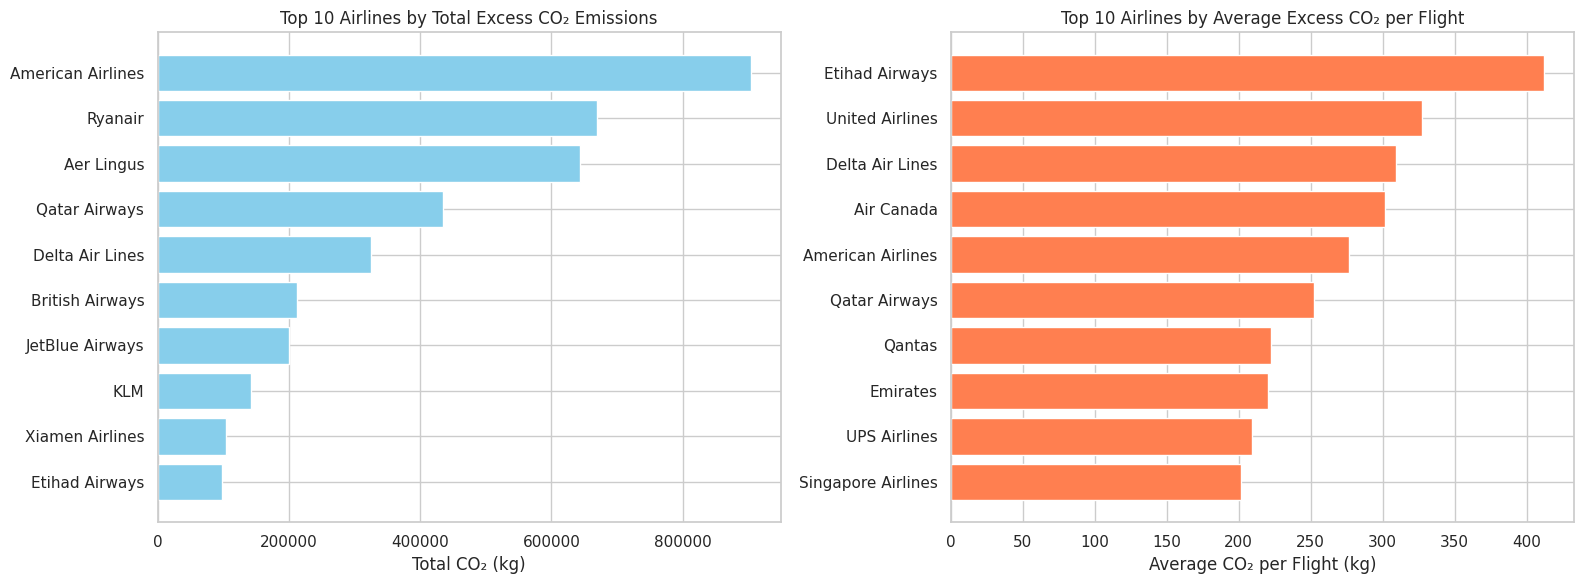

In [70]:
flights_per_airline = df.groupby('Airline').size().reset_index(name='num_flights')

# Merge with existing total CO2 data (make sure it's not just top 10 yet)
total_emissions = df.groupby('Airline')['ExcessCO2_kg'].sum().reset_index()
airline_emissions = pd.merge(total_emissions, flights_per_airline, on='Airline')

# Calculate average emission per flight
airline_emissions['avg_emission_per_flight'] = airline_emissions['ExcessCO2_kg'] / airline_emissions['num_flights']

# Get top 10 airlines by total emissions
top_airlines = airline_emissions.sort_values('ExcessCO2_kg', ascending=False).head(10)
# Using previously calculated top_airlines and ranked_avg_emissions
ranked_avg_emissions = airline_emissions.sort_values('avg_emission_per_flight', ascending=False).head(10)
# Create a single figure with two side-by-side bar charts
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Total CO₂ emissions bar chart
axs[0].barh(top_airlines['Airline'], top_airlines['ExcessCO2_kg'], color='skyblue')
axs[0].set_title('Top 10 Airlines by Total Excess CO₂ Emissions')
axs[0].set_xlabel('Total CO₂ (kg)')
axs[0].invert_yaxis()

# Average CO₂ per flight bar chart
axs[1].barh(ranked_avg_emissions['Airline'], ranked_avg_emissions['avg_emission_per_flight'], color='coral')
axs[1].set_title('Top 10 Airlines by Average Excess CO₂ per Flight')
axs[1].set_xlabel('Average CO₂ per Flight (kg)')
axs[1].invert_yaxis()

# Display the combined plots
plt.tight_layout()
plt.show()

<ipython-input-71-274ab9fcd531>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Aircraft Size Label', y='ExcessCO2_kg', palette='viridis')


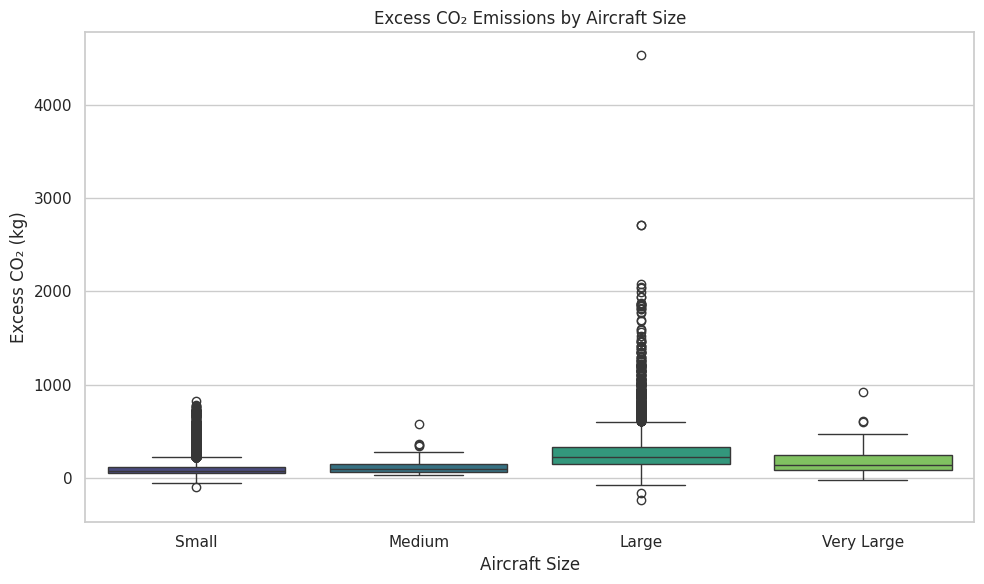

<ipython-input-71-274ab9fcd531>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Aircraft Size Label', y='ExcessCO2_kg', estimator='mean', palette='magma')


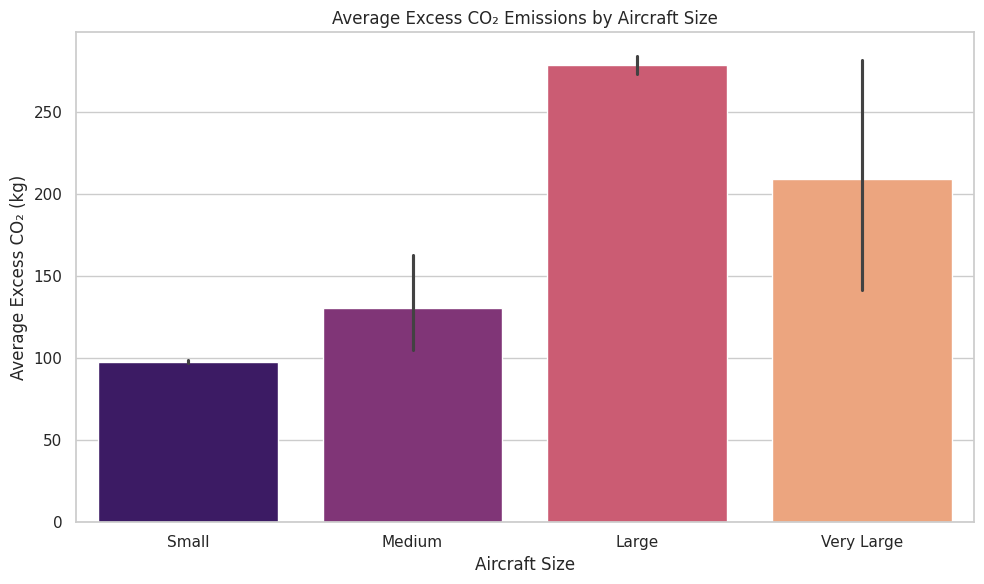

In [71]:
# Map aircraft size numbers to labels
aircraft_size_labels = {
    1: 'Small',
    2: 'Medium',
    3: 'Large',
    4: 'Very Large'
}
df['Aircraft Size Label'] = df['Aircraft Size'].map(aircraft_size_labels)

# Set category order explicitly
size_order = ['Small', 'Medium', 'Large', 'Very Large']
df['Aircraft Size Label'] = pd.Categorical(df['Aircraft Size Label'], categories=size_order, ordered=True)

# Set up the plot style
sns.set(style="whitegrid")

# Boxplot of Excess CO₂ by Aircraft Size
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Aircraft Size Label', y='ExcessCO2_kg', palette='viridis')
plt.title('Excess CO₂ Emissions by Aircraft Size')
plt.xlabel('Aircraft Size')
plt.ylabel('Excess CO₂ (kg)')
plt.tight_layout()
plt.show()

# Barplot of mean Excess CO₂ by Aircraft Size
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Aircraft Size Label', y='ExcessCO2_kg', estimator='mean', palette='magma')
plt.title('Average Excess CO₂ Emissions by Aircraft Size')
plt.xlabel('Aircraft Size')
plt.ylabel('Average Excess CO₂ (kg)')
plt.tight_layout()
plt.show()


In [72]:
unique_airlines = df['Airline'].unique()
print(unique_airlines)


['Ryanair' 'Xiamen Airlines' 'China Eastern Airlines' 'Kenya Airways'
 'Delta Air Lines' 'KLM' 'Aer Lingus' 'JetBlue Airways'
 'American Airlines' 'British Airways' 'Etihad Airways' 'Air France'
 'Iberia' 'SAS' 'DHL Air' 'Qatar Airways' 'Qantas' 'Emirates' 'Air Canada'
 'Wizz Air' 'United Airlines' 'Lufthansa' 'Singapore Airlines' 'ANA'
 'Turkish Airlines' 'TAP Air Portugal' 'UPS Airlines' 'FedEx'
 'Virgin Atlantic' 'Norwegian']


In [73]:
airline_type_map = {
    'Ryanair': 'Low-Cost',
    'Wizz Air': 'Low-Cost',
    'Norwegian': 'Low-Cost',

    'Xiamen Airlines': 'Full-Service',
    'China Eastern Airlines': 'Full-Service',
    'Kenya Airways': 'Full-Service',
    'Delta Air Lines': 'Full-Service',
    'KLM': 'Full-Service',
    'Aer Lingus': 'Full-Service',
    'JetBlue Airways': 'Full-Service',
    'American Airlines': 'Full-Service',
    'British Airways': 'Full-Service',
    'Etihad Airways': 'Full-Service',
    'Air France': 'Full-Service',
    'Iberia': 'Full-Service',
    'SAS': 'Full-Service',
    'Qatar Airways': 'Full-Service',
    'Qantas': 'Full-Service',
    'Emirates': 'Full-Service',
    'Air Canada': 'Full-Service',
    'United Airlines': 'Full-Service',
    'Lufthansa': 'Full-Service',
    'Singapore Airlines': 'Full-Service',
    'ANA': 'Full-Service',
    'Turkish Airlines': 'Full-Service',
    'TAP Air Portugal': 'Full-Service',
    'Virgin Atlantic': 'Full-Service',

    'DHL Air': 'Cargo',
    'UPS Airlines': 'Cargo',
    'FedEx': 'Cargo'
}


In [74]:
df['Airline Type'] = df['Airline'].map(airline_type_map)


<ipython-input-75-b81d91d486ce>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Airline Type', x='Departure Delay', data=avg_delay, palette='Set2')


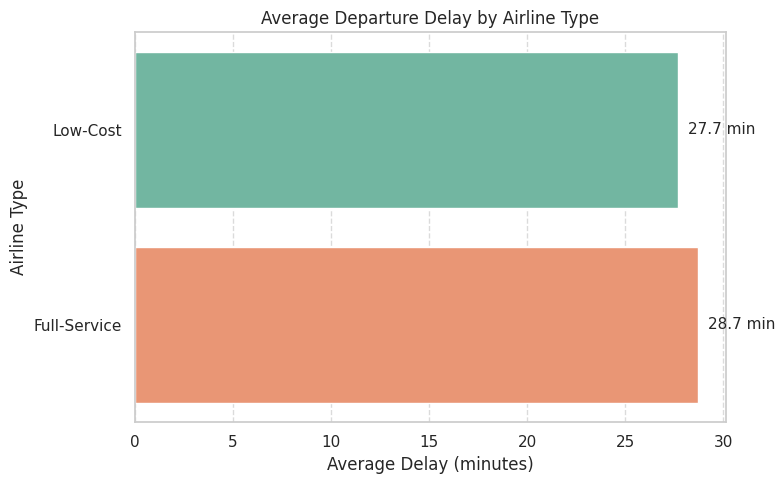

In [75]:
# average delay by airline type
avg_delay = df[df['Airline Type'].isin(['Low-Cost', 'Full-Service'])]\
              .groupby('Airline Type')['Departure Delay'].mean().reset_index()

# Sort values
avg_delay = avg_delay.sort_values(by='Departure Delay', ascending=True)

# Plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(y='Airline Type', x='Departure Delay', data=avg_delay, palette='Set2')

#data labels
for bar in ax.patches:
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{bar.get_width():.1f} min', va='center', fontsize=11)

# Titles and labels
plt.title('Average Departure Delay by Airline Type')
plt.xlabel('Average Delay (minutes)')
plt.ylabel('Airline Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

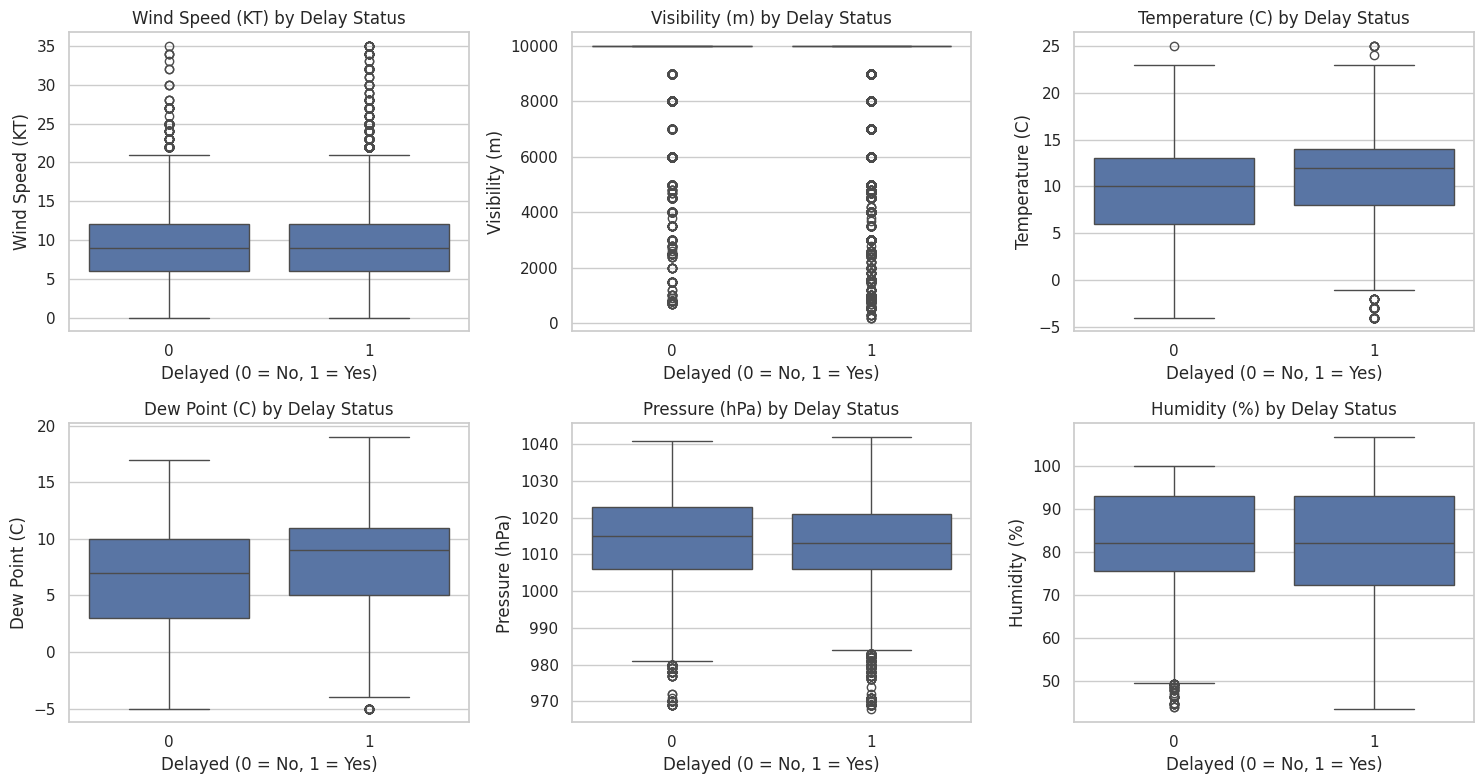

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the weather variables you want to visualize
weather_vars = ['Wind Speed (KT)', 'Visibility (m)', 'Temperature (C)',
                'Dew Point (C)', 'Pressure (hPa)', 'Humidity (%)']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

# Plot boxplots
for i, var in enumerate(weather_vars):
    sns.boxplot(data=df, x='Delayed', y=var, ax=axes[i])
    axes[i].set_title(f'{var} by Delay Status')
    axes[i].set_xlabel('Delayed (0 = No, 1 = Yes)')
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()


# Financial Analysis

In [77]:
# data from the paper
data = {
    'Aircraft Size': ['Small', 'Medium', 'Large', 'Very Large'],
    'Gate Delay Cost (€)': [72, 102, 161, 188],
    'Taxi Delay Cost (€)': [99, 134, 196, 229],
    'Average Delay Cost (€)': [(72 + 99)/2, (102 + 134)/2, (161 + 196)/2, (188 + 229)/2]
}

#DataFrame
delay_cost_df = pd.DataFrame(data)

# 2 decimal places
for col in ['Gate Delay Cost (€)', 'Taxi Delay Cost (€)', 'Average Delay Cost (€)']:
    delay_cost_df[col] = delay_cost_df[col].apply(lambda x: f"€{x:,.2f}")

# Display the DataFrame
print(delay_cost_df.to_string(index=False))





Aircraft Size Gate Delay Cost (€) Taxi Delay Cost (€) Average Delay Cost (€)
        Small              €72.00              €99.00                 €85.50
       Medium             €102.00             €134.00                €118.00
        Large             €161.00             €196.00                €178.50
   Very Large             €188.00             €229.00                €208.50


<ipython-input-78-b970735362b4>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=airline_costs.head(top_n), x='Airline', y='Total Delay Cost €', palette='flare')


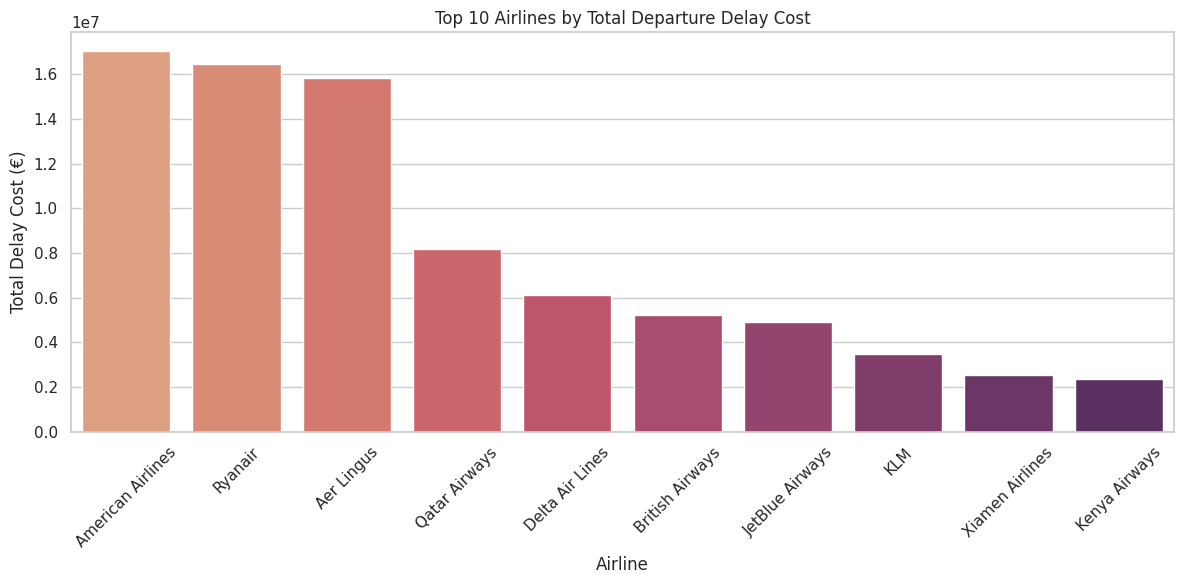

In [78]:
# Mapping aircraft size to descriptive labels and delay cost per minute
aircraft_size_labels = {
    1: 'Small',
    2: 'Medium',
    3: 'Large',
    4: 'Very Large'
}

delay_cost_per_minute = {
    'Small': 85.5,
    'Medium': 118,
    'Large': 178.5,
    'Very Large': 208.5
}

# Mapping aircraft size labels and costs
df['Aircraft Size Label'] = df['Aircraft Size'].map(aircraft_size_labels)
df['Delay Cost €/min'] = df['Aircraft Size Label'].map(delay_cost_per_minute)

# total cost per flight
df['Total Delay Cost €'] = df['Departure Delay'] * df['Delay Cost €/min']

# Group by airline and sum total delay cost
airline_costs = df.groupby('Airline')['Total Delay Cost €'].sum().sort_values(ascending=False).reset_index()

# Top 10 airlines by total delay cost
top_n = 10
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=airline_costs.head(top_n), x='Airline', y='Total Delay Cost €', palette='flare')
plt.title(f'Top {top_n} Airlines by Total Departure Delay Cost')
plt.xlabel('Airline')
plt.ylabel('Total Delay Cost (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



<ipython-input-79-4f40a2d432f8>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_stats = df.groupby('Month').agg({


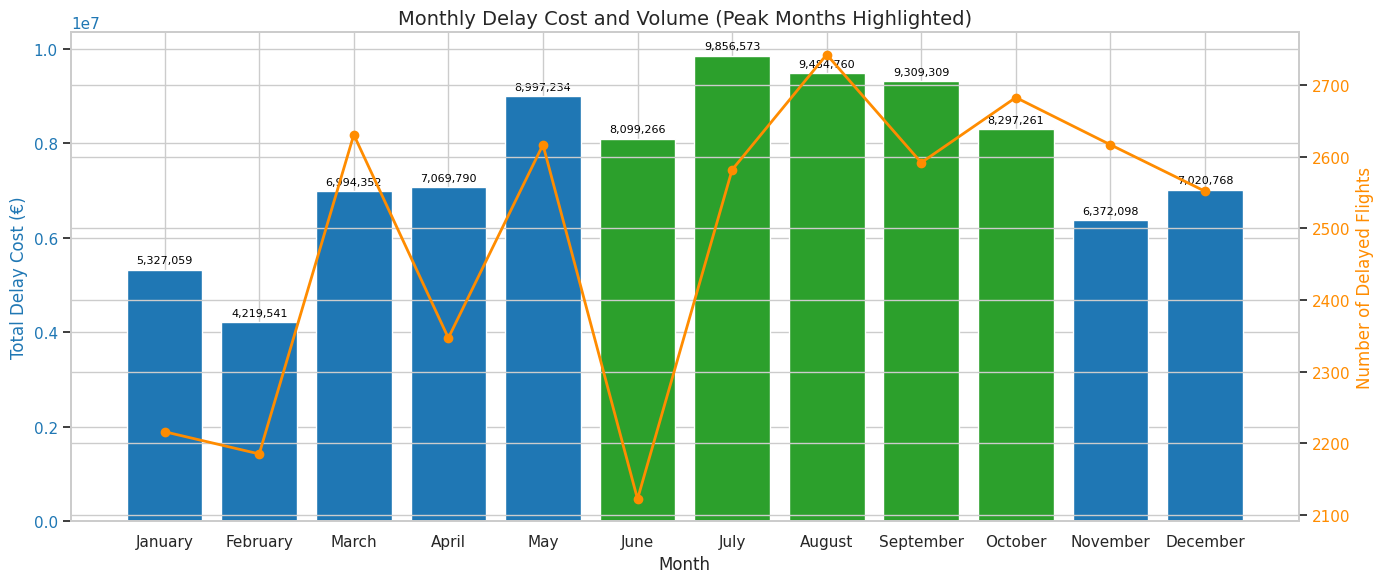

In [79]:
# Ensure date column is in datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extracted and ordered the month names
df['Month'] = df['Date'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Group by month
monthly_stats = df.groupby('Month').agg({
    'Total Delay Cost €': 'sum',
    'Departure Delay': 'count'
}).reset_index().rename(columns={'Departure Delay': 'Delayed Flights'})

# Defined peak months
peak_months = ['June', 'July', 'August', 'September', 'October']

bar_colors = ['#2ca02c' if month in peak_months else '#1f77b4' for month in monthly_stats['Month']]

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Total Delay Cost
bars = ax1.bar(monthly_stats['Month'], monthly_stats['Total Delay Cost €'],
               color=bar_colors, label='Total Delay Cost (€)')
ax1.set_ylabel('Total Delay Cost (€)', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# bar labels
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:,.0f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=8, color='black')

# Line chart: Number of delayed flights
ax2 = ax1.twinx()
line = ax2.plot(monthly_stats['Month'], monthly_stats['Delayed Flights'],
                color='darkorange', marker='o', linewidth=2, label='Delayed Flights')
ax2.set_ylabel('Number of Delayed Flights', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Title and formatting
plt.title('Monthly Delay Cost and Volume (Peak Months Highlighted)', fontsize=14)
ax1.set_xlabel('Month')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




<ipython-input-80-bc8e5495e401>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_costs = df.groupby('Month')['Total Delay Cost €'].sum().reset_index()


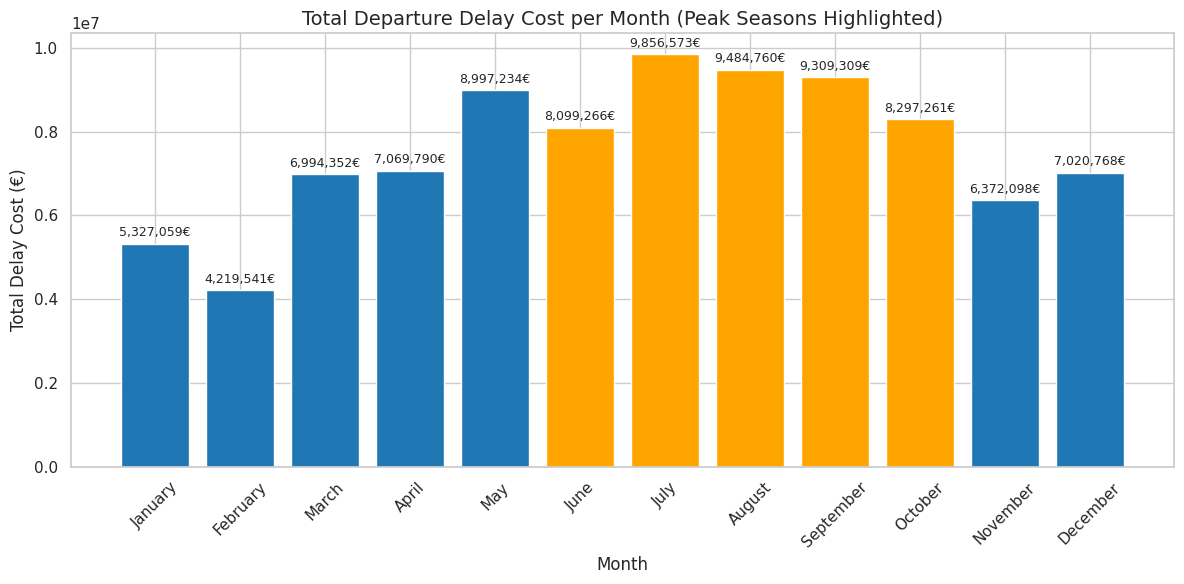

In [80]:
# Ensure date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract month name
df['Month'] = df['Date'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

# Grouped by month and calculated total delay cost
monthly_costs = df.groupby('Month')['Total Delay Cost €'].sum().reset_index()

# peak months to highlight
peak_months = ['June', 'July', 'August', 'September', 'October']

# Assign colors
colors = ['orange' if month in peak_months else '#1f77b4' for month in monthly_costs['Month']]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(monthly_costs['Month'], monthly_costs['Total Delay Cost €'], color=colors)


for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:,.0f}€',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords='offset points',
                 ha='center', va='bottom', fontsize=9)

#labels and title
plt.title('Total Departure Delay Cost per Month (Peak Seasons Highlighted)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Delay Cost (€)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



<ipython-input-81-39cf9ac0100a>:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


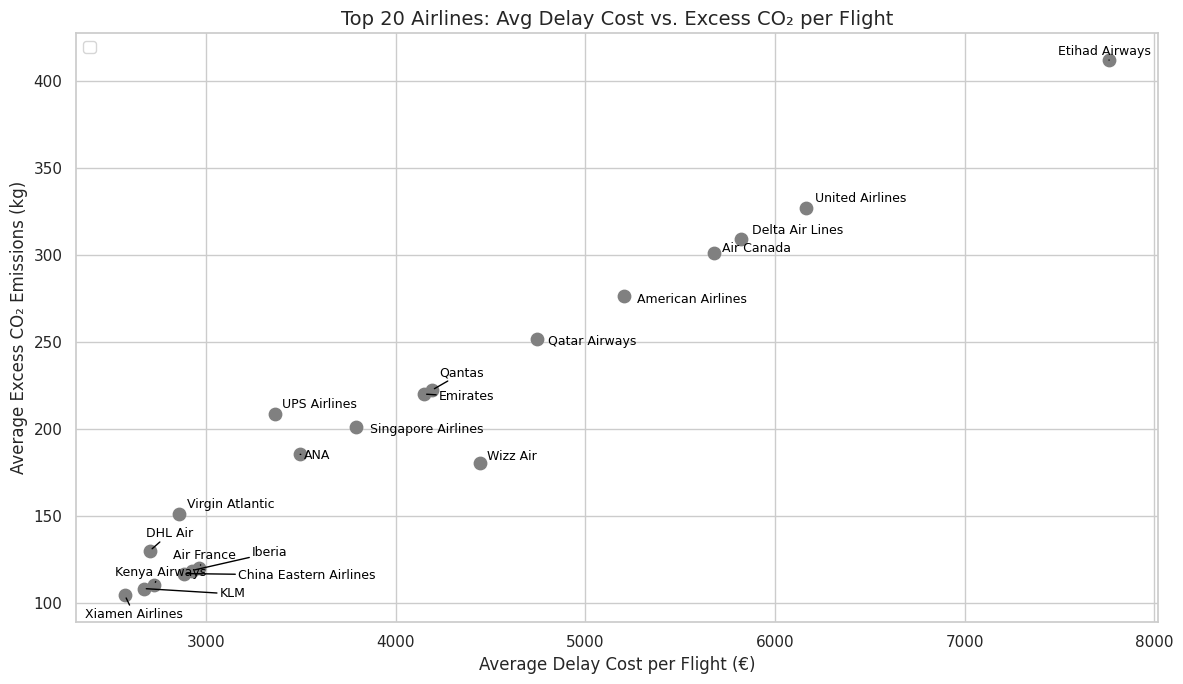

In [81]:
# Prepare the same top 20
combo_df = df.groupby('Airline').agg({
    'Total Delay Cost €': 'mean',
    'ExcessCO2_kg': 'mean'
}).reset_index()

irish_airlines = ['Ryanair', 'Aer Lingus']
combo_df['Is Irish'] = combo_df['Airline'].isin(irish_airlines)
combo_df['Color'] = combo_df['Is Irish'].map({True: 'green', False: 'grey'})

# top 20 airlines by delay cost
top20_df = combo_df.sort_values(by='Total Delay Cost €', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 7))
texts = []

# Scatter points
for _, row in top20_df.iterrows():
    plt.scatter(row['Total Delay Cost €'], row['ExcessCO2_kg'], color=row['Color'], s=80)
    texts.append(
        plt.text(
            row['Total Delay Cost €'],
            row['ExcessCO2_kg'],
            row['Airline'],
            fontsize=9,
            color='green' if row['Is Irish'] else 'black'
        )
    )

# Adjusted text to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))


# Labels & title
plt.title('Top 20 Airlines: Avg Delay Cost vs. Excess CO₂ per Flight', fontsize=14)
plt.xlabel('Average Delay Cost per Flight (€)', fontsize=12)
plt.ylabel('Average Excess CO₂ Emissions (kg)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()





<ipython-input-82-aaed1ea0e329>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


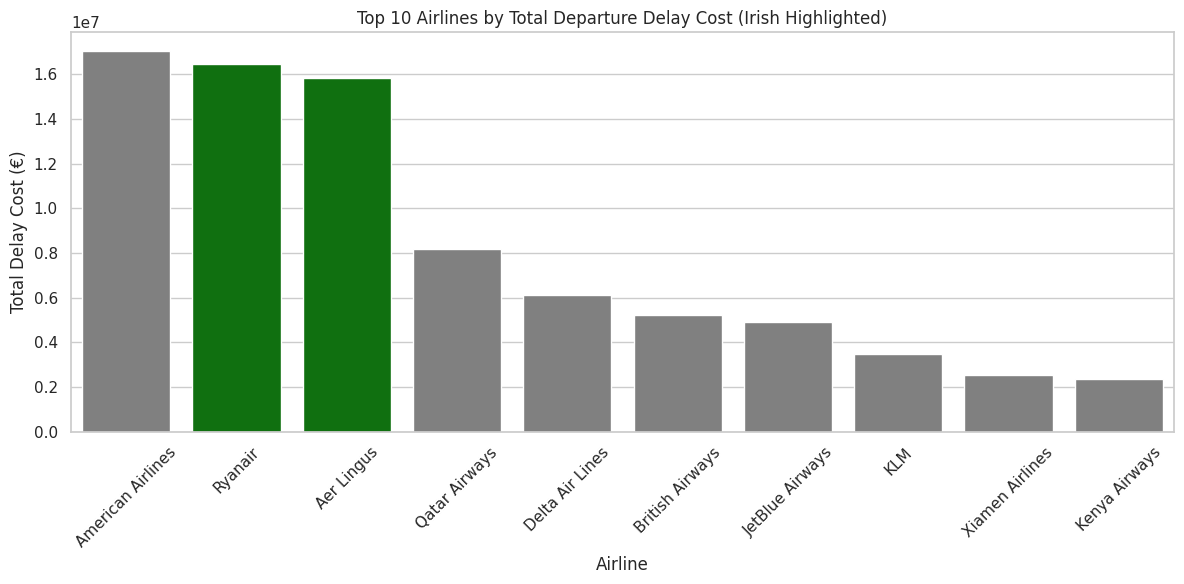

In [82]:
# Irish airlines
irish_airlines = ['Ryanair', 'Aer Lingus']

# new column to tag Irish airlines
airline_costs['Is Irish'] = airline_costs['Airline'].isin(irish_airlines)

# Plot with color mapping
plt.figure(figsize=(12, 6))
colors = ['green' if is_irish else 'grey' for is_irish in airline_costs['Is Irish'].head(top_n)]
sns.barplot(
    data=airline_costs.head(top_n),
    x='Airline',
    y='Total Delay Cost €',
    palette=colors
)
plt.title(f'Top {top_n} Airlines by Total Departure Delay Cost (Irish Highlighted)')
plt.xlabel('Airline')
plt.ylabel('Total Delay Cost (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



<ipython-input-84-40a884f9d5bc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


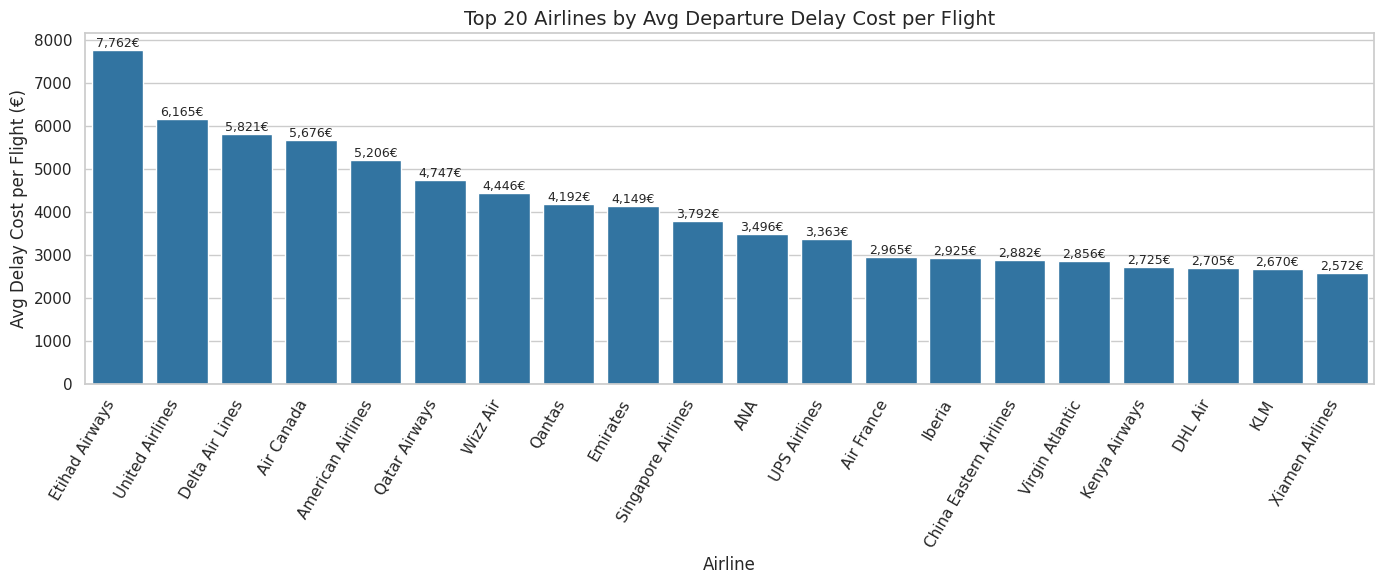

In [84]:
# AVG Cost
airline_costs = df.groupby('Airline')['Total Delay Cost €'].mean().sort_values(ascending=False).reset_index()

airline_costs['Is Irish'] = airline_costs['Airline'].isin(irish_airlines)

# top 20
top_n = 20
top20_df = airline_costs.head(top_n)

# Assign color: green for Irish, blue for others
colors = ['green' if is_irish else '#1f77b4' for is_irish in top20_df['Is Irish']]

# Plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=top20_df,
    x='Airline',
    y='Total Delay Cost €',
    palette=colors
)

plt.xticks(rotation=60, ha='right')

# value labels
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():,.0f}€",
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom',
        fontsize=9
    )

# Titles and labels
plt.title(f'Top {top_n} Airlines by Avg Departure Delay Cost per Flight', fontsize=14)
plt.xlabel('Airline', fontsize=12)
plt.ylabel('Avg Delay Cost per Flight (€)', fontsize=12)
plt.tight_layout()
plt.show()


# Temporal

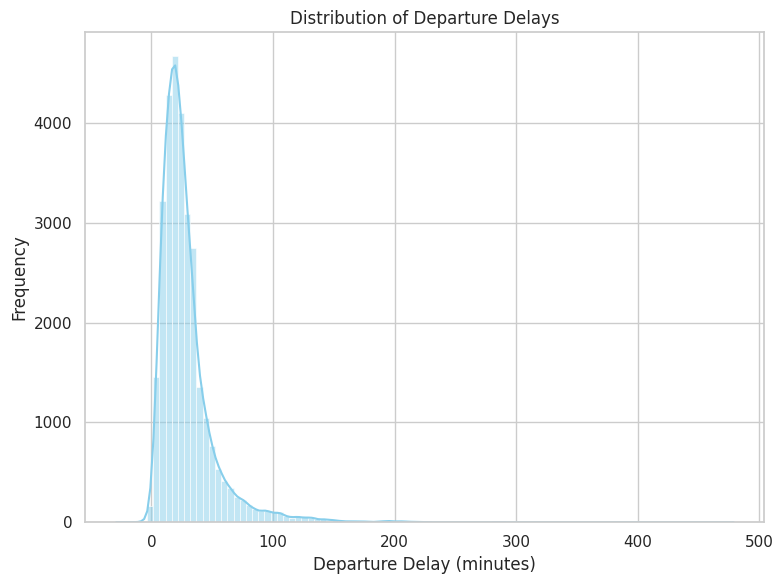

In [40]:
# distribution of departure delays

plt.figure(figsize=(8, 6))
sns.histplot(df['Departure Delay'], bins=100, kde=True, color='skyblue')
plt.title('Distribution of Departure Delays')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


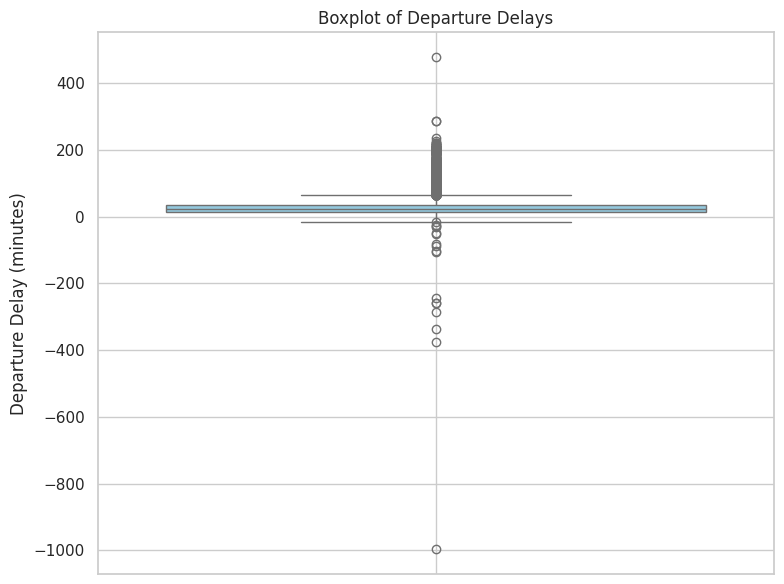

In [41]:
# Parse datetime columns
df['Scheduled Departure'] = pd.to_datetime(df['Scheduled Departure'])
df['Actual Departure'] = pd.to_datetime(df['Actual Departure'])

# Calculate delay in minutes
df['delay_minutes'] = (df['Actual Departure'] - df['Scheduled Departure']).dt.total_seconds() / 60

# Boxplot of departure delays including outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='delay_minutes', color='skyblue')
plt.title('Boxplot of Departure Delays')
plt.ylabel('Departure Delay (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
#removed unrealistic early departures (delay < -60 minutes)
df = df[df['delay_minutes'] > -60]

#display shape
df.shape


(29876, 44)

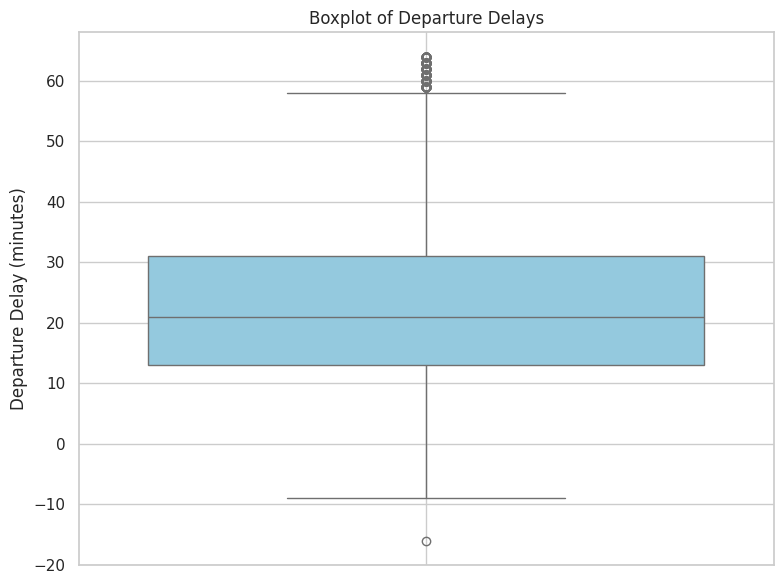

In [43]:
# Calculate IQR to remove outliers
Q1 = df['delay_minutes'].quantile(0.25)
Q3 = df['delay_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame
df_filtered = df[(df['delay_minutes'] >= lower_bound) & (df['delay_minutes'] <= upper_bound)]

# Boxplot with outliers removed
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_filtered, y='delay_minutes', color='skyblue')
plt.title('Boxplot of Departure Delays')
plt.ylabel('Departure Delay (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()


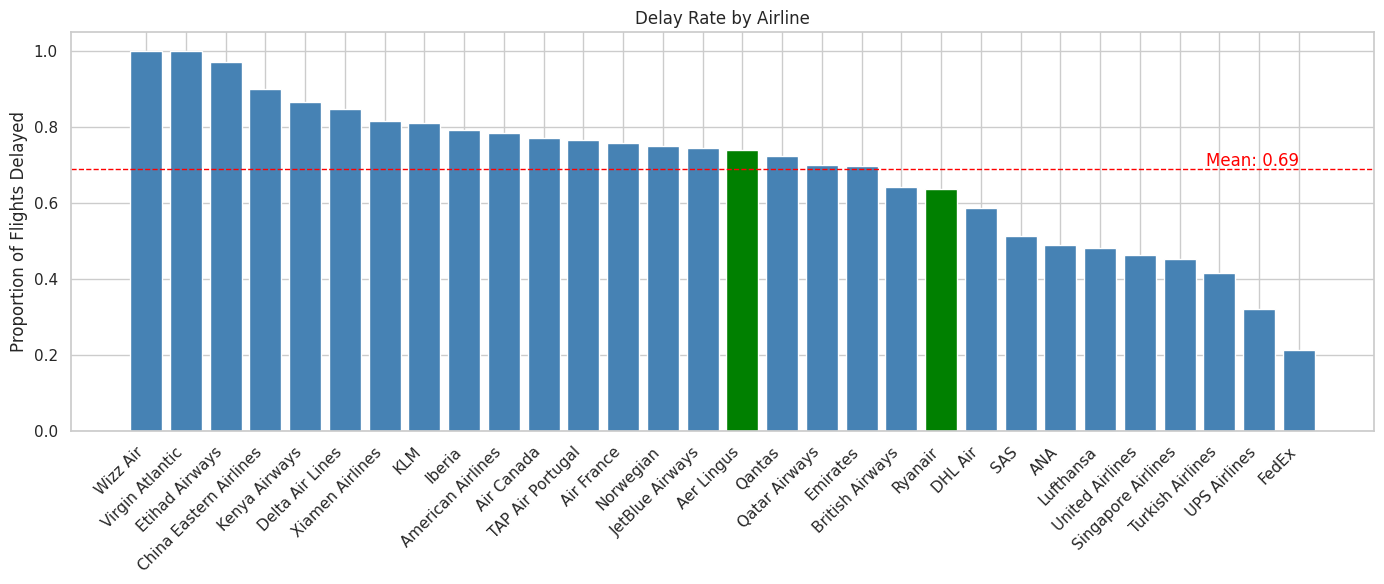

In [85]:
#delay rate
airline_delay_rate = df.groupby("Airline")["Delayed"].mean().sort_values(ascending=False)


#highlight Irish airlines
colors = ['green' if airline in irish_airlines else 'steelblue' for airline in airline_delay_rate.index]

# Plot
plt.figure(figsize=(14,6))
bars = plt.bar(airline_delay_rate.index, airline_delay_rate.values, color=colors)
plt.title("Delay Rate by Airline")
plt.ylabel("Proportion of Flights Delayed")
plt.xticks(rotation=45, ha='right')

#horizontal line at the mean delay rate
mean_delay = airline_delay_rate.mean()
plt.axhline(mean_delay, color='red', linestyle='--', linewidth=1)
plt.text(len(airline_delay_rate)-1, mean_delay + 0.01, f"Mean: {mean_delay:.2f}", color='red', ha='right')

plt.tight_layout()
plt.show()



<ipython-input-45-9c708226f31b>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_filtered, x='peak_season', y='Departure Delay', palette='Set2')


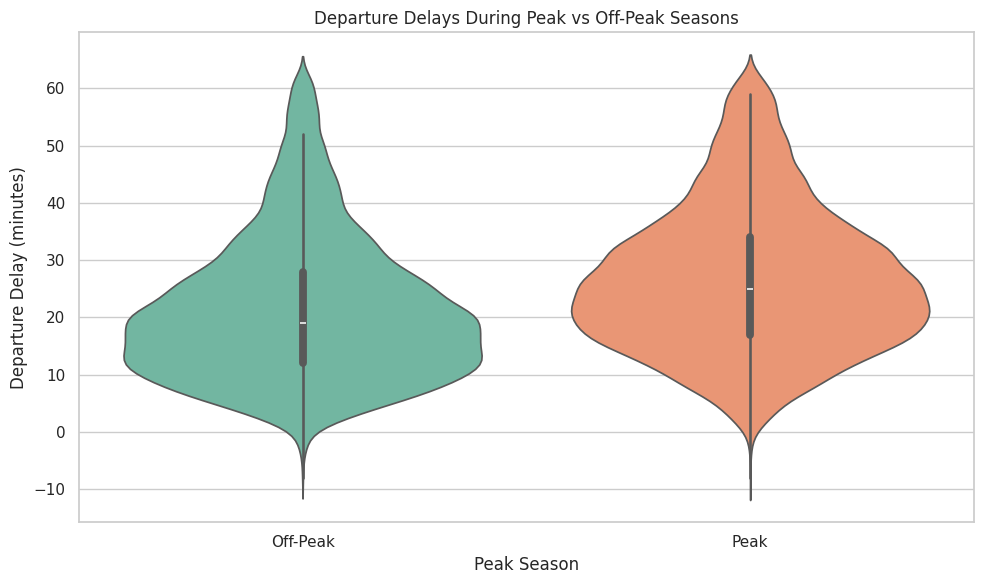

In [45]:
# Remove outliers from the Departure Delay column using the IQR method
Q1 = df['Departure Delay'].quantile(0.25)
Q3 = df['Departure Delay'].quantile(0.75)
IQR = Q3 - Q1

# lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtered the dataframe to remove outliers
df_filtered = df[(df['Departure Delay'] >= lower_bound) & (df['Departure Delay'] <= upper_bound)]

#violin plot again without outliers
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_filtered, x='peak_season', y='Departure Delay', palette='Set2')
plt.title('Departure Delays During Peak vs Off-Peak Seasons')
plt.xlabel('Peak Season')
plt.ylabel('Departure Delay (minutes)')
plt.xticks([0, 1], ['Off-Peak', 'Peak'])
plt.tight_layout()
plt.show()


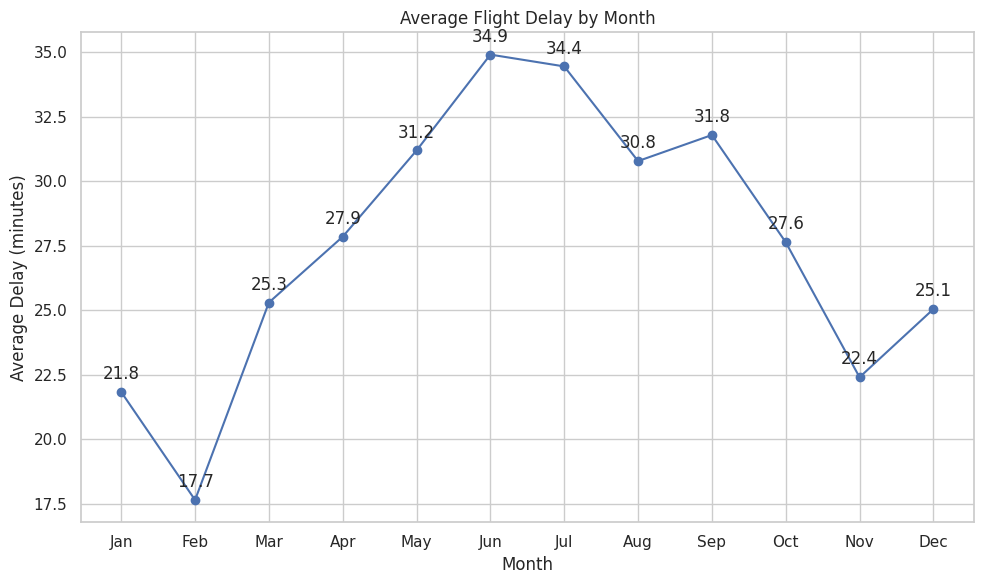

In [86]:

# delay in minutes
df['delay_minutes'] = (df['Actual Departure'] - df['Scheduled Departure']).dt.total_seconds() / 60

# Extracted month from scheduled departure
df['month'] = df['Scheduled Departure'].dt.month

# average delay per month
monthly_avg_delay = df.groupby('month')['delay_minutes'].mean().reset_index()

monthly_avg_delay['month'] = monthly_avg_delay['month'].apply(lambda x: calendar.month_abbr[x])

# Sort months in calendar order
monthly_avg_delay['month'] = pd.Categorical(monthly_avg_delay['month'],
                                            categories=calendar.month_abbr[1:],
                                            ordered=True)
monthly_avg_delay = monthly_avg_delay.sort_values('month')
# line plot with data labels
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_delay['month'], monthly_avg_delay['delay_minutes'], marker='o', linestyle='-')
plt.title('Average Flight Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)

# data labels
for i, value in enumerate(monthly_avg_delay['delay_minutes']):
    plt.text(monthly_avg_delay['month'].iloc[i], value + 0.5, f"{value:.1f}", ha='center')

plt.tight_layout()
plt.show()




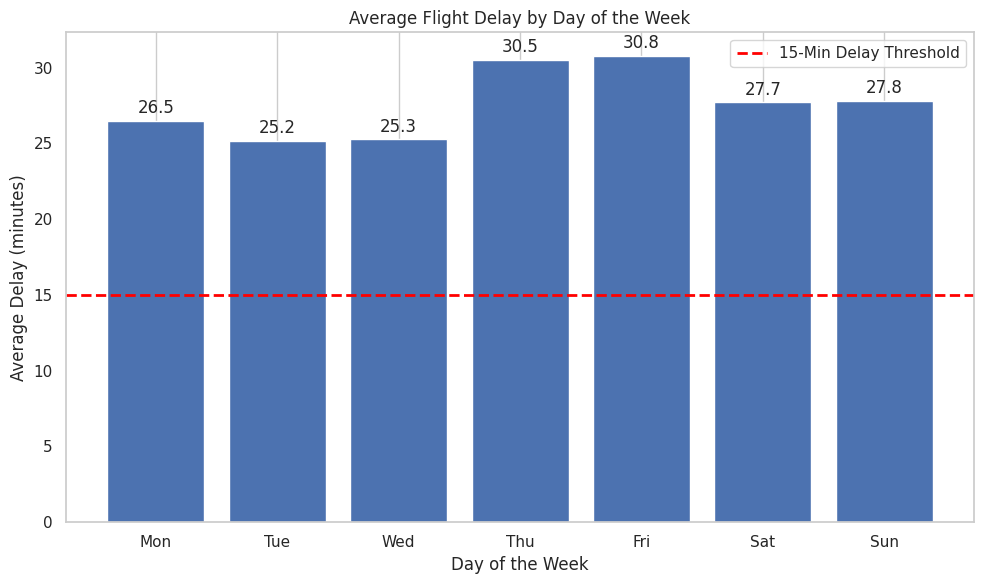

In [87]:
df['delay_minutes'] = (df['Actual Departure'] - df['Scheduled Departure']).dt.total_seconds() / 60

# day of the week
df['day_of_week'] = df['Scheduled Departure'].dt.dayofweek
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df['day_name'] = df['day_of_week'].map(day_map)

# average delay by day of the week
avg_delay_by_day = df.groupby('day_name')['delay_minutes'].mean().reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']).reset_index()

# Line plot
# Bar plot with a horizontal line at 15 minutes
plt.figure(figsize=(10, 6))
plt.bar(avg_delay_by_day['day_name'], avg_delay_by_day['delay_minutes'])

#labels on top of bars
for i, value in enumerate(avg_delay_by_day['delay_minutes']):
    plt.text(avg_delay_by_day['day_name'][i], value + 0.5, f"{value:.1f}", ha='center')

#horizontal line at 15 minutes
plt.axhline(y=15, color='red', linestyle='--', linewidth=2, label='15-Min Delay Threshold')

plt.title('Average Flight Delay by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (minutes)')
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()




In [88]:
# Preprocess the data to get the day of the week and delay minutes
df['delay_minutes'] = (df['Actual Departure'] - df['Scheduled Departure']).dt.total_seconds() / 60

# day of the week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df['Scheduled Departure'].dt.dayofweek
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df['day_name'] = df['day_of_week'].map(day_map)

# Perform ANOVA to test if there are significant differences in delays by day of the week
anova_result = stats.f_oneway(
    df[df['day_name'] == 'Mon']['delay_minutes'],
    df[df['day_name'] == 'Tue']['delay_minutes'],
    df[df['day_name'] == 'Wed']['delay_minutes'],
    df[df['day_name'] == 'Thu']['delay_minutes'],
    df[df['day_name'] == 'Fri']['delay_minutes'],
    df[df['day_name'] == 'Sat']['delay_minutes'],
    df[df['day_name'] == 'Sun']['delay_minutes']
)

anova_result


F_onewayResult(statistic=np.float64(37.192047003906325), pvalue=np.float64(3.301167656627397e-45))

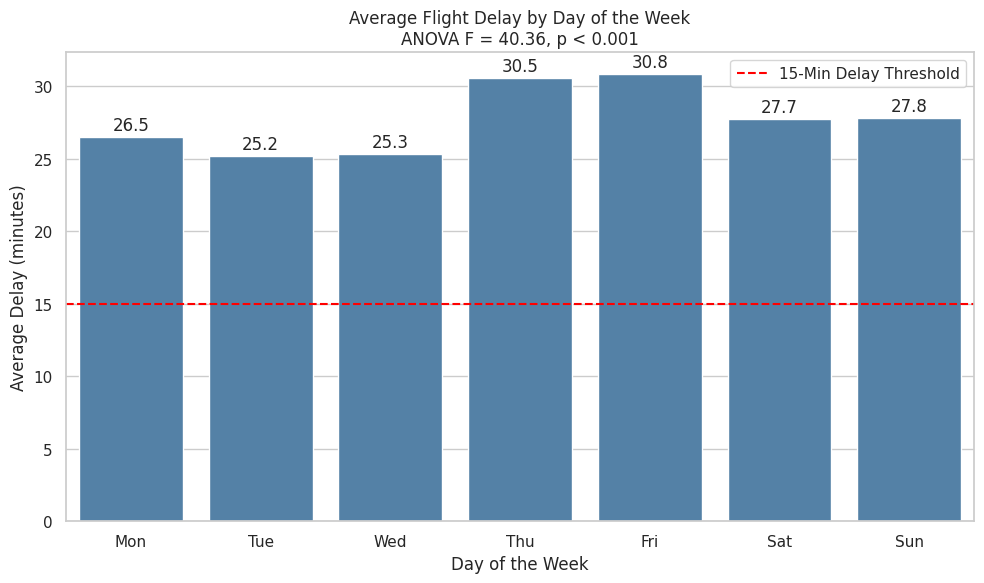

In [91]:
mean_delays = df.groupby('day_name')['delay_minutes'].mean().reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_delays.index, y=mean_delays.values, color='steelblue')

for i, val in enumerate(mean_delays.values):
    plt.text(i, val + 0.5, f'{val:.1f}', ha='center')

plt.axhline(15, color='red', linestyle='--', label='15-Min Delay Threshold')
plt.title('Average Flight Delay by Day of the Week\nANOVA F = 40.36, p < 0.001')
plt.xlabel('Day of the Week')
plt.ylabel('Average Delay (minutes)')
plt.legend()
plt.tight_layout()
plt.show()


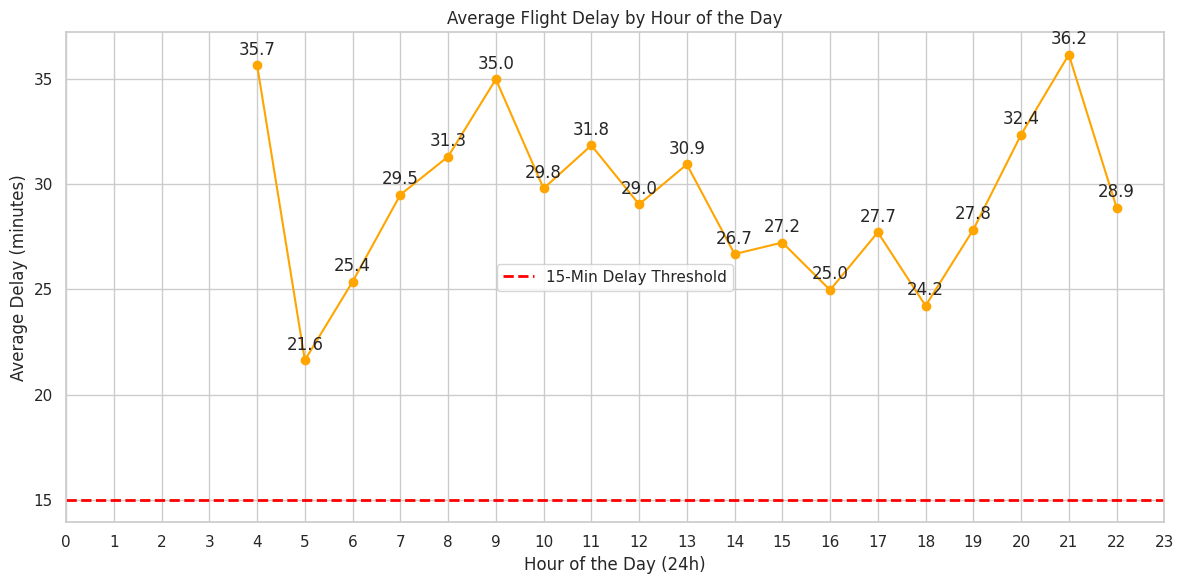

In [90]:
# hour column is extracted from valid datetime
df['hour'] = df['Scheduled Departure'].dt.hour

# Filter out rows with invalid delay values
df_valid = df[df['delay_minutes'].notna() & (df['delay_minutes'] >= 0)]

# flight count and average delay per hour
hourly_summary = df_valid.groupby('hour').agg(
    avg_delay=('delay_minutes', 'mean'),
    flight_count=('delay_minutes', 'count')
).reset_index()

# Filtered out low-volume hours (fewer than 30 flights)
hourly_summary = hourly_summary[hourly_summary['flight_count'] >= 30]

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(hourly_summary['hour'], hourly_summary['avg_delay'], marker='o', linestyle='-', color='orange')

# Data labels
for i, value in enumerate(hourly_summary['avg_delay']):
    plt.text(hourly_summary['hour'].iloc[i], value + 0.5, f"{value:.1f}", ha='center')

# 15-minute delay threshold
plt.axhline(y=15, color='red', linestyle='--', linewidth=2, label='15-Min Delay Threshold')

# formatting
plt.title('Average Flight Delay by Hour of the Day')
plt.xlabel('Hour of the Day (24h)')
plt.ylabel('Average Delay (minutes)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



<ipython-input-50-6b3ffcfce73b>:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_delay_by_duration = df.groupby('duration_bin')['delay_minutes'].mean().reset_index()
<ipython-input-50-6b3ffcfce73b>:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


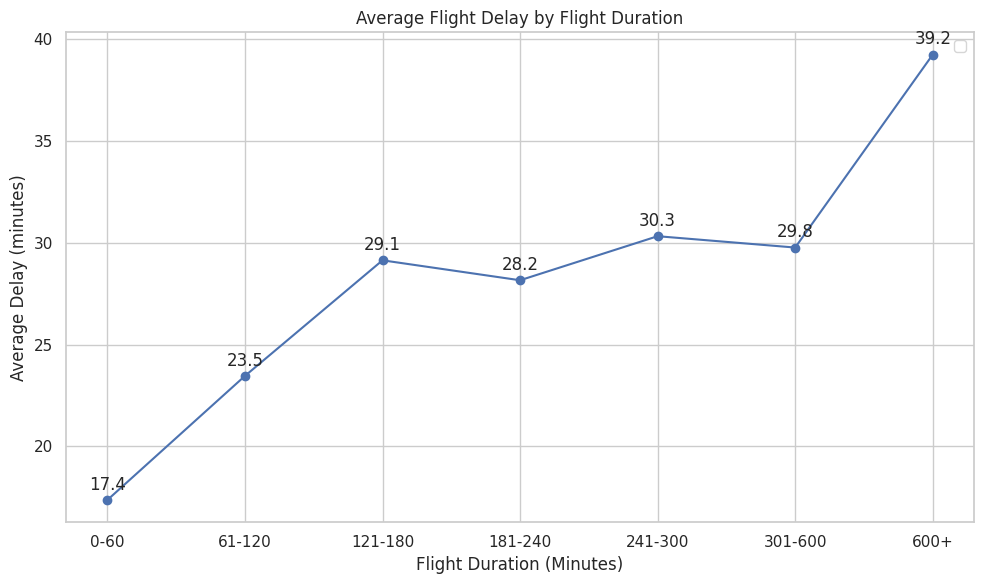

In [50]:
# bins for flight duration in minutes
bins = [0, 60, 120, 180, 240, 300, 600, 1000]
labels = ['0-60', '61-120', '121-180', '181-240', '241-300', '301-600', '600+']
df['duration_bin'] = pd.cut(df['Flight Duration (Minutes)'], bins=bins, labels=labels, right=False)

# average delay per duration bin
avg_delay_by_duration = df.groupby('duration_bin')['delay_minutes'].mean().reset_index()

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(avg_delay_by_duration['duration_bin'], avg_delay_by_duration['delay_minutes'], marker='o', linestyle='-')

#data labels
for i, value in enumerate(avg_delay_by_duration['delay_minutes']):
    plt.text(avg_delay_by_duration['duration_bin'][i], value + 0.5, f"{value:.1f}", ha='center')


plt.title('Average Flight Delay by Flight Duration')
plt.xlabel('Flight Duration (Minutes)')
plt.ylabel('Average Delay (minutes)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


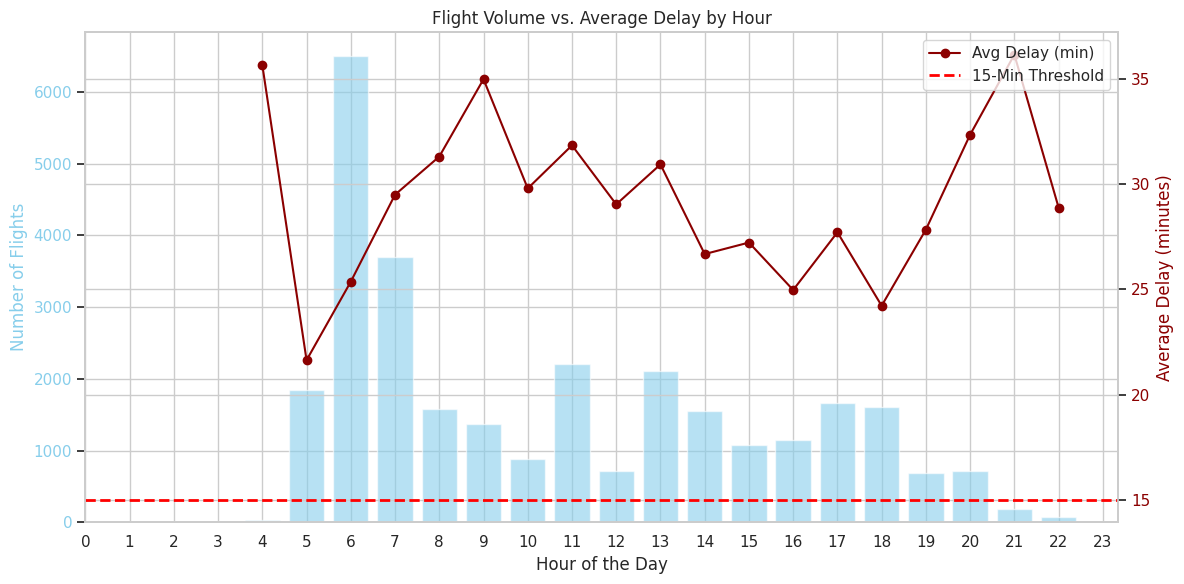

In [51]:
# Removed hours 2 and 3 in addition to 23
hourly_summary_cleaned = hourly_summary[~hourly_summary['hour'].isin([23, 2, 3])]

# plot without hours 2, 3, and 23 not operating
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for flight volume
ax1.bar(hourly_summary_cleaned['hour'], hourly_summary_cleaned['flight_count'], alpha=0.6, color='skyblue')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Flights', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Line chart for average delay
ax2 = ax1.twinx()
ax2.plot(hourly_summary_cleaned['hour'], hourly_summary_cleaned['avg_delay'], color='darkred', marker='o', label='Avg Delay (min)')
ax2.axhline(y=15, color='red', linestyle='--', linewidth=2, label='15-Min Threshold')
ax2.set_ylabel('Average Delay (minutes)', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

# Labels and formatting
plt.title('Flight Volume vs. Average Delay by Hour')
ax1.grid(True)
ax2.legend(loc='upper right')
plt.xticks(range(0, 24))  # 0 to 22 only
plt.tight_layout()
plt.show()




# Weather

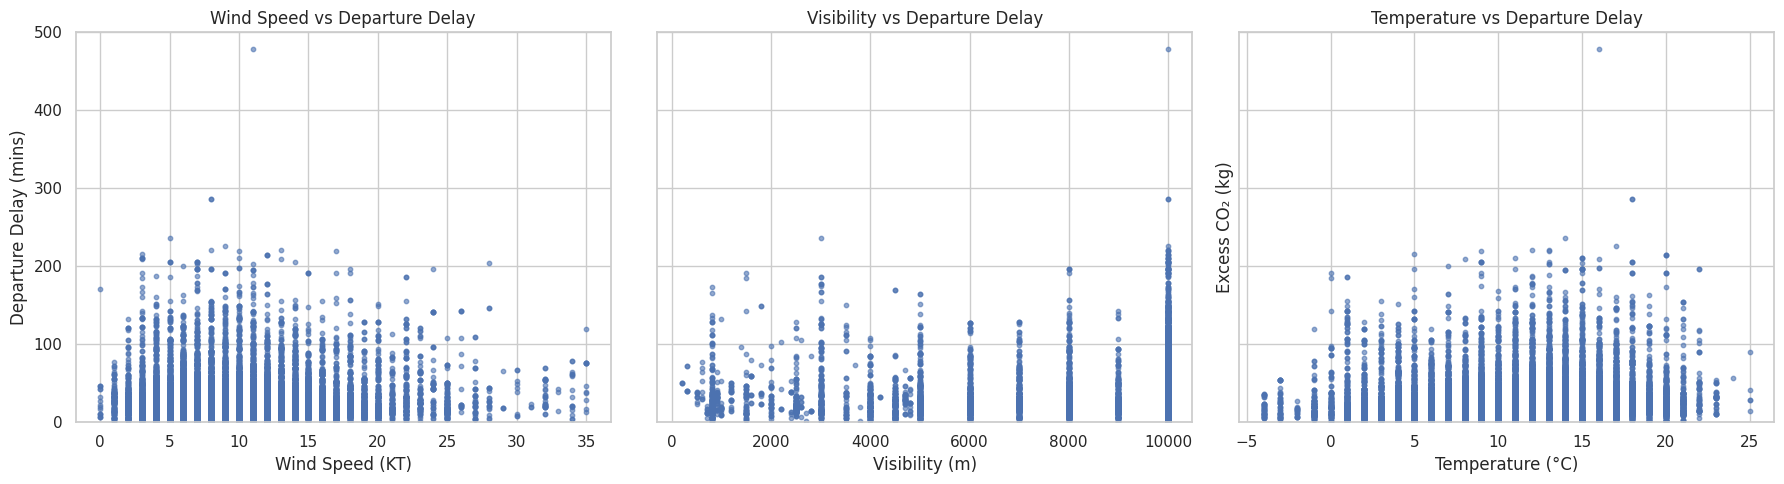

In [ ]:
# subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Scatter 1: Wind Speed vs Departure Delay
axs[0].scatter(df['Wind Speed (KT)'], df['Departure Delay'], s=10, alpha=0.6)
axs[0].set_title('Wind Speed vs Departure Delay')
axs[0].set_xlabel('Wind Speed (KT)')
axs[0].set_ylabel('Departure Delay (mins)')
axs[0].set_ylim(0, 500)

# Scatter 2: Visibility vs Departure Delay
axs[1].scatter(df['Visibility (m)'], df['Departure Delay'], s=10, alpha=0.6)
axs[1].set_title('Visibility vs Departure Delay')
axs[1].set_xlabel('Visibility (m)')
axs[1].set_ylabel('')

# Scatter 3: Temperature vs Excess CO2
axs[2].scatter(df['Temperature (C)'], df['Departure Delay'], s=10, alpha=0.6)
axs[2].set_title('Temperature vs Departure Delay')
axs[2].set_xlabel('Temperature (°C)')
axs[2].set_ylabel('Excess CO₂ (kg)')

plt.tight_layout()
plt.show()


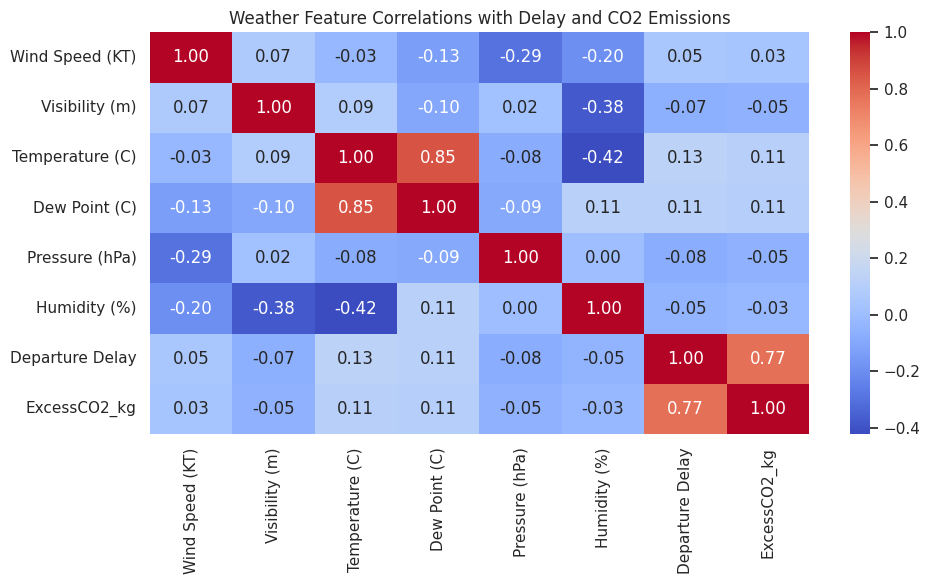

In [ ]:
#only the weather-related columns from the dataframe
weather_related_columns = [
    'Wind Speed (KT)',
    'Visibility (m)',
    'Temperature (C)',
    'Dew Point (C)',
    'Pressure (hPa)',
    'Humidity (%)',
    'Departure Delay',
    'ExcessCO2_kg'
]

# Filtered the dataframe to just those columns
weather_corr_df = df[weather_related_columns]

# correlation matrix
weather_corr_matrix = weather_corr_df.corr()

#heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(weather_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Weather Feature Correlations with Delay and CO2 Emissions')
plt.tight_layout()
plt.show()


<ipython-input-53-c61238fb658e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Temp Category', y='delay_minutes', palette='coolwarm')


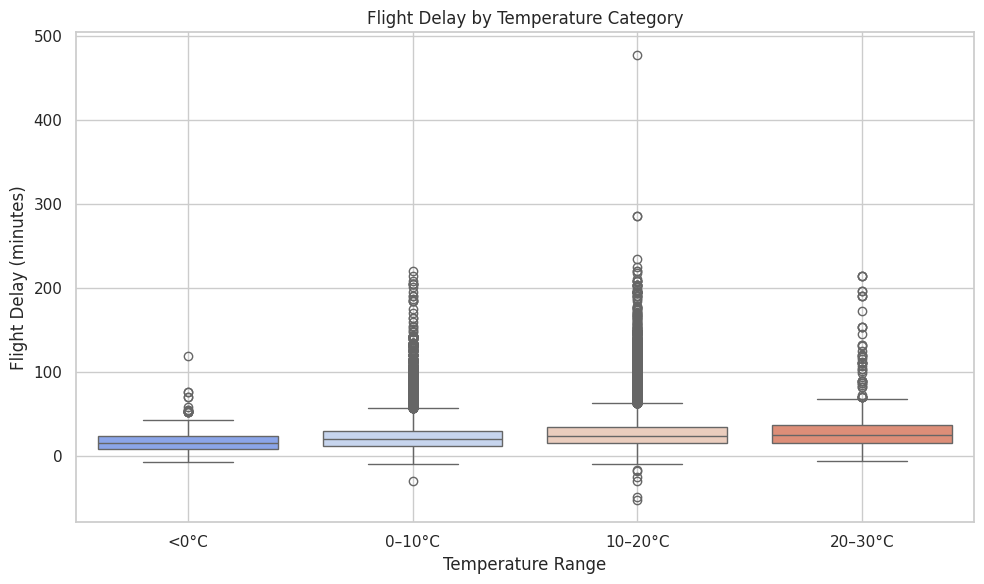

In [ ]:

temp_bins = [-10, 0, 10, 20, 30]
temp_labels = ['<0°C', '0–10°C', '10–20°C', '20–30°C']

# temperature category column
df['Temp Category'] = pd.cut(df['Temperature (C)'], bins=temp_bins, labels=temp_labels, right=False)

# Boxplot for delay by temperature category
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Temp Category', y='delay_minutes', palette='coolwarm')

plt.title('Flight Delay by Temperature Category')
plt.xlabel('Temperature Range')
plt.ylabel('Flight Delay (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()


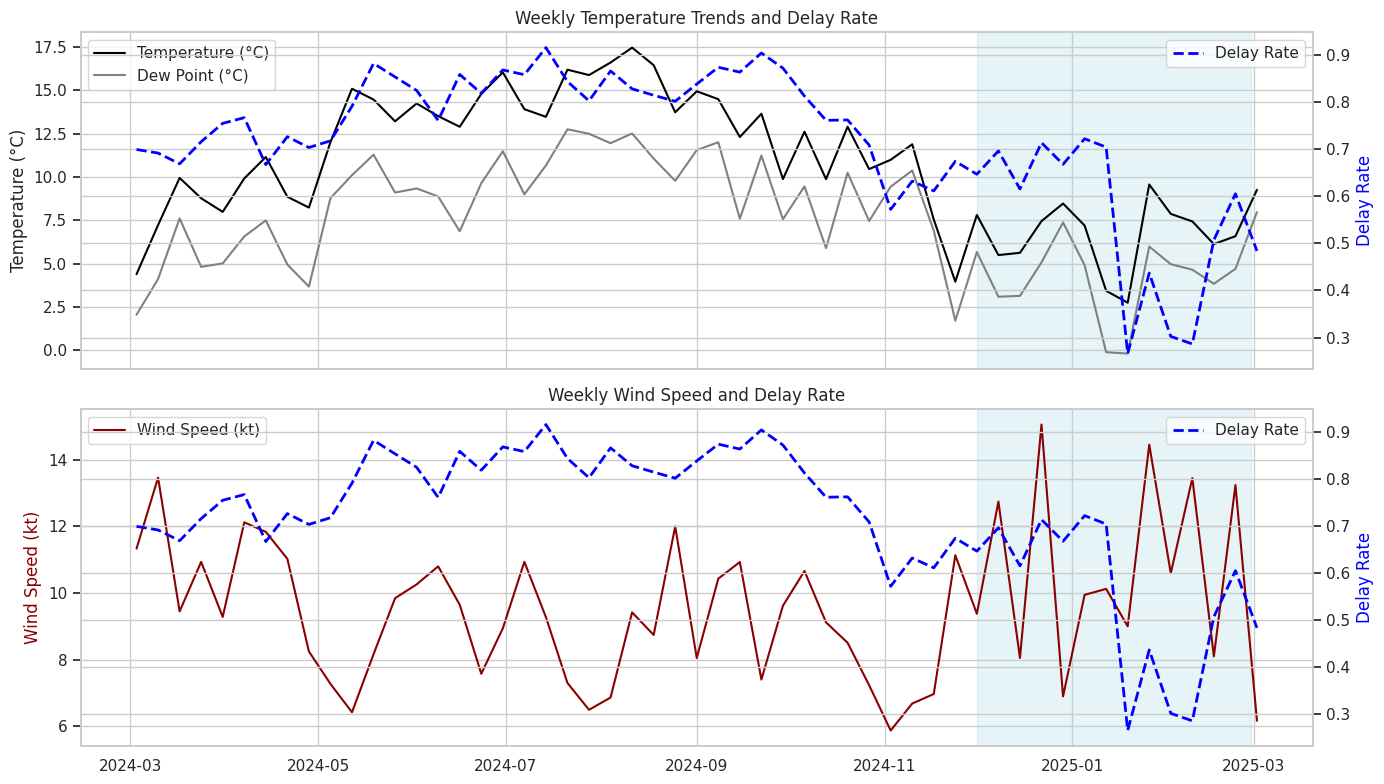

In [ ]:
# Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Weekly averages
weekly_weather = df.set_index('Date').resample('W').agg({
    'Temperature (C)': 'mean',
    'Dew Point (C)': 'mean',
    'Wind Speed (KT)': 'mean'
}).apply(pd.to_numeric, errors='coerce')

#Weekly delay rate
weekly_delays = df.set_index('Date').resample('W').agg({'Delayed': ['sum', 'count']})
weekly_delays.columns = ['Delayed_Flights', 'Total_Flights']
weekly_delays['Delay_Rate'] = weekly_delays['Delayed_Flights'] / weekly_delays['Total_Flights']

# correlation coefficients
correlation_df = weekly_weather.join(weekly_delays['Delay_Rate'])
correlations = correlation_df.corr()['Delay_Rate'].drop('Delay_Rate')

fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Define seasons
winter_shade = [(mdates.datestr2num('2024-12-01'), mdates.datestr2num('2025-02-28'))]
summer_shade = [(mdates.datestr2num('2024-06-01'), mdates.datestr2num('2024-08-31'))]

# Panel 1: Temperature & Dew Point + Delay Rate
axs[0].plot(weekly_weather.index, weekly_weather['Temperature (C)'], label='Temperature (°C)', color='black')
axs[0].plot(weekly_weather.index, weekly_weather['Dew Point (C)'], label='Dew Point (°C)', color='gray')
axs[0].set_ylabel('Temperature (°C)')
axs[0].legend(loc='upper left')
axs[0].set_title('Weekly Temperature Trends and Delay Rate')

# shaded winter region
for start, end in winter_shade:
    axs[0].axvspan(start, end, color='lightblue', alpha=0.3, label='Winter (approx)')

# y-axis for delay rate
ax0b = axs[0].twinx()
ax0b.plot(weekly_delays.index, weekly_delays['Delay_Rate'], label='Delay Rate', color='blue', linestyle='--', linewidth=2)
ax0b.set_ylabel('Delay Rate', color='blue')
ax0b.legend(loc='upper right')

# Panel 2: Wind Speed + Delay Rate
axs[1].plot(weekly_weather.index, weekly_weather['Wind Speed (KT)'], label='Wind Speed (kt)', color='darkred')
axs[1].set_ylabel('Wind Speed (kt)', color='darkred')
axs[1].legend(loc='upper left')
axs[1].set_title('Weekly Wind Speed and Delay Rate')

for start, end in winter_shade:
    axs[1].axvspan(start, end, color='lightblue', alpha=0.3)

# Delay Rate secondary axis
ax1b = axs[1].twinx()
ax1b.plot(weekly_delays.index, weekly_delays['Delay_Rate'], label='Delay Rate', color='blue', linestyle='--', linewidth=2)
ax1b.set_ylabel('Delay Rate', color='blue')
ax1b.legend(loc='upper right')

plt.xlabel('Week')
plt.tight_layout()
plt.show()





In [ ]:
# Define the real weather-related variable names to test
weather_vars = ['Wind Speed (KT)', 'Visibility (m)', 'Temperature (C)', 'Dew Point (C)', 'Pressure (hPa)', 'Humidity (%)']

# Perform t-tests for each variable
weather_results_real = []
for var in weather_vars:
    group1 = df[df['Delayed'] == 1][var]
    group0 = df[df['Delayed'] == 0][var]
    t_stat, p_val = ttest_ind(group1, group0, nan_policy='omit')
    significant = 'Yes' if p_val < 0.05 else 'No'
    weather_results_real.append({
        'Variable': var,
        't-statistic': round(t_stat, 2),
        'p-value': round(p_val, 4),
        'Significant (Y/N)': significant
    })

# summary table
weather_summary_real_df = pd.DataFrame(weather_results_real)

weather_summary_real_df

,Variable,t-statistic,p-value,Significant (Y/N)
0,Wind Speed (KT),2.07,0.0387,Yes
1,Visibility (m),-4.41,0.0000,Yes
2,Temperature (C),28.00,0.0000,Yes
3,Dew Point (C),27.49,0.0000,Yes
4,Pressure (hPa),-12.50,0.0000,Yes
5,Humidity (%),-4.99,0.0000,Yes
